The dataset Tiny ImageNet has to be in the 'data/' folder

Instruction to download and extract the data:

wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

unzip tiny-imagenet-200.zip

rm tiny-imagenet-200.zip

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


['/device:CPU:0', '/device:GPU:0']


# 0. Loading the data

### TinyImageNet does not have labels for the testing data. We will use the 10k validation images for the testing data.

In [2]:
#Generate dataset

###### TRAINING DATA #######
#Load Training images and labels
train_directory = "./data/tiny-imagenet-200/train" 
image_list=[]
label_list=[]

label_dic={} #convert label str to int from 0 



for l,sub_dir in enumerate(os.listdir(train_directory)):
    if not sub_dir in label_dic:
        label_dic[sub_dir]=l
    sub_dir_name=os.path.join(train_directory,sub_dir,'images')
    n=0
    for file in os.listdir(sub_dir_name):
        filename = os.fsdecode(file)
        if filename.endswith(".JPEG")  or filename.endswith(".jpg") or filename.endswith(".png"):
            img=np.array(Image.open(os.path.join(sub_dir_name,file)))
            if(img.shape == (64, 64, 3)): #removing images without 3 channels
                image_list.append(img)
                label_list.append(int(label_dic[sub_dir]))
                n+=1
    print(n,'pictures in folder',sub_dir,sep=' ' )
            
X_tot=np.array(image_list)
y_tot=np.array(label_list)

###### TEST DATA #######

#getting the labels from the txt file
df = pd.read_table('./data/tiny-imagenet-200/val/val_annotations.txt', header=None)
test_labels={} 
for index, row in df.iterrows():
    test_labels[str(row[0])]= row[1]


test_directory = "./data/tiny-imagenet-200/val/images" 

test_image_list=[]
test_label_list=[]

for file in os.listdir(test_directory):
    filename = os.fsdecode(file)
  
    if filename.endswith(".JPEG")  or filename.endswith(".jpg") or filename.endswith(".png"):
        img=np.array(Image.open(os.path.join(test_directory,file)))
        if(img.shape == (64, 64, 3)): #removing images without 3 channels
            test_image_list.append(img)
            test_label_list.append(label_dic[test_labels[filename]])
            
X_test=np.array(test_image_list)
y_test=tf.keras.utils.to_categorical(np.array(test_label_list))

497 pictures in folder n03617480
499 pictures in folder n09332890
499 pictures in folder n01917289
497 pictures in folder n04398044
496 pictures in folder n03977966
491 pictures in folder n04486054
485 pictures in folder n02481823
499 pictures in folder n01910747
500 pictures in folder n01443537
495 pictures in folder n02823428
497 pictures in folder n04254777
487 pictures in folder n03837869
500 pictures in folder n07695742
493 pictures in folder n03983396
500 pictures in folder n04597913
495 pictures in folder n02395406
500 pictures in folder n02132136
492 pictures in folder n04259630
500 pictures in folder n02279972
493 pictures in folder n04371430
500 pictures in folder n03980874
454 pictures in folder n03763968
499 pictures in folder n07768694
497 pictures in folder n02948072
497 pictures in folder n02231487
497 pictures in folder n02206856
494 pictures in folder n09428293
498 pictures in folder n03100240
473 pictures in folder n04532670
495 pictures in folder n01944390
495 pictur

In [3]:
shuffler=np.random.RandomState(seed=10).permutation(len(X_tot))
X_tot = X_tot[shuffler]
y_tot = y_tot[shuffler]
y_tot=tf.keras.utils.to_categorical(y_tot)

X_train = X_tot[5000:]
y_train =  y_tot[5000:]
X_val = X_tot[:5000]
y_val =  y_tot[:5000]


print('test data:')
print(X_test.shape)
print(y_test.shape)

print('train data:')
print(X_train.shape)
print(y_train.shape)

print('val data:')
print(X_val.shape)
print(y_val.shape)

test data:
(9832, 64, 64, 3)
(9832, 200)
train data:
(93179, 64, 64, 3)
(93179, 200)
val data:
(5000, 64, 64, 3)
(5000, 200)


#### Saving the variables allows faster loading in the future

In [4]:
#save for future use without having to reload from the images folders
np.save('data/X_test.npy', X_test)
np.save('data/y_test.npy', y_test)
np.save('data/X_train.npy', X_train)
np.save('data/y_train.npy', y_train)
np.save('data/X_val.npy', X_val)
np.save('data/y_val.npy', y_val) 



In [2]:
print('script running in '+os.path.abspath("."))
X_test = np.load('./data/X_test.npy')
y_test = np.load('./data/y_test.npy')
X_train = np.load('./data/X_train.npy')
y_train = np.load('./data/y_train.npy')
X_val = np.load('./data/X_val.npy')
y_val = np.load('./data/y_val.npy')

script running in /home/ecbm4040/envTF24/e4040-2021fall-project-fren-an3078-wab2138-av3023


# 1. Using ResNet34 with ImageNet

### We use our custom resnet model generator to get any resnet 

Imagenet has 200 different labels and is downsampled from ImageNet to a resolution of 64x64 

In [3]:
from utils.custom_resnet import custom_resnet34
from utils.train_TinyImageNet_SE_ResNet import tinyImageNet_resnet_train
# tinyImageNet_resnet_train(model,path,X_train,y_train,X_val,y_val,data_aug=False,learning_rate=0.6,steps=14,epochs=45,batch_size=128,es_patience=8)
resnet_34=custom_resnet34(input_shape=(64,64,3),n_classes=200)
resnet_34.summary()

Model: "custom_resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 32, 32, 64)   0           conv1_bn[0][0]                   
____________________________________________________________________________________

## 1.1 Resnet34 without data augmentation

In [4]:
hist_resnet_34= tinyImageNet_resnet_train(resnet_34,
                          './models/tinyImageNet/resnet_34_best.hdf5', #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=False, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

Epoch 1/60
steps before lr change:  20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 79s 100ms/step - loss: 5.9251 - acc: 0.0082 - val_loss: 5.1338 - val_acc: 0.0142

Epoch 00001: val_acc improved from -inf to 0.01420, saving model to ./models/tinyImageNet/resnet_34_best.hdf5
Epoch 2/60
steps before lr change:  19

Epoch 00002: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 70s 97ms/step - loss: 5.1177 - acc: 0.0139 - val_loss: 5.1026 - val_acc: 0.0156

Epoch 00002: val_acc improved from 0.01420 to 0.01560, saving model to ./models/tinyImageNet/resnet_34_best.hdf5
Epoch 3/60
steps before lr change:  18

Epoch 00003: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 70s 96ms/step - loss: 5.0819 - acc: 0.0153 - val_loss: 5.2727 - val_acc: 0.0088

Epoch 00003: val_acc did not improve from

Epoch 25/60
steps before lr change:  16

Epoch 00025: LearningRateScheduler reducing learning rate to 0.06000000238418579.
727/727 [==============================] - 70s 97ms/step - loss: 2.3092 - acc: 0.4311 - val_loss: 3.2096 - val_acc: 0.2846

Epoch 00025: val_acc did not improve from 0.28820
Epoch 26/60
steps before lr change:  15

Epoch 00026: LearningRateScheduler reducing learning rate to 0.06000000238418579.
727/727 [==============================] - 70s 97ms/step - loss: 2.2363 - acc: 0.4484 - val_loss: 3.2372 - val_acc: 0.2892

Epoch 00026: val_acc improved from 0.28820 to 0.28920, saving model to ./models/tinyImageNet/resnet_34_best.hdf5
Epoch 27/60
steps before lr change:  14

Epoch 00027: LearningRateScheduler reducing learning rate to 0.06000000238418579.
727/727 [==============================] - 71s 97ms/step - loss: 2.1282 - acc: 0.4717 - val_loss: 3.3179 - val_acc: 0.2794

Epoch 00027: val_acc did not improve from 0.28920
Epoch 28/60
steps before lr change:  13

Epoch

Accuracy and loss graphs

In [ ]:
### Best saved model is at epoch 15

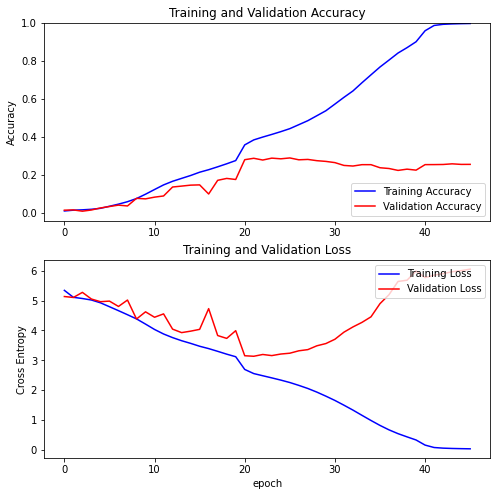

In [5]:
from utils.train_TinyImageNet_SE_ResNet import plot_model
plot_model(hist_resnet_34)

#### Why we used check points

In [6]:
# Evaluate the model
loss, acc = resnet_34.evaluate(X_test, y_test, verbose=2)
print("last epoch model, accuracy: {:5.2f}%".format(100 * acc))

# reload from saved weights:
model = custom_resnet34(input_shape=(64,64,3),n_classes=200)
model.load_weights('./models/tinyImageNet/resnet_34_best.hdf5')

# Evaluate the model
model.compile(loss='categorical_crossentropy', metrics = ['acc'])
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("best saved model, accuracy: {:5.2f}%".format(100 * acc))

308/308 - 4s - loss: 6.1013 - acc: 0.2551
last epoch model, accuracy: 25.51%
308/308 - 5s - loss: 3.2606 - acc: 0.2855
best saved model, accuracy: 28.55%


### Top n scores

In [7]:
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

308/308 - 5s - loss: 3.2606 - acc: 0.2855
custom_resnet34
model accuracy: 28.55%
top 1 accuracy: 0.28549632
top 3 accuracy: 0.4555533
top 5 accuracy: 0.5509561


## 1.2 Resnet34 With data augmentation

In [3]:
from utils.train_TinyImageNet_SE_ResNet import tinyImageNet_resnet_train,plot_model

In [ ]:
from utils.custom_resnet import custom_resnet34

resnet_34_aug=custom_resnet34(input_shape=(64,64,3),n_classes=200)
path='./models/tinyImageNet/resnet_34_aug_best.hdf5'
history_resnet_34_aug= tinyImageNet_resnet_train(resnet_34_aug,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=True, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

Epoch 1/60
steps before lr change:  20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 164s 174ms/step - loss: 5.8390 - acc: 0.0088 - val_loss: 5.1087 - val_acc: 0.0154

Epoch 00001: val_acc improved from -inf to 0.01540, saving model to ./models/tinyImageNet/resnet_34_aug_best.hdf5
Epoch 2/60
steps before lr change:  19

Epoch 00002: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 125s 172ms/step - loss: 5.0017 - acc: 0.0239 - val_loss: 4.8904 - val_acc: 0.0336

Epoch 00002: val_acc improved from 0.01540 to 0.03360, saving model to ./models/tinyImageNet/resnet_34_aug_best.hdf5
Epoch 3/60
steps before lr change:  18

Epoch 00003: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 126s 173ms/step - loss: 4.7751 - acc: 0.0416 - val_loss: 4.6312 - val_acc: 0.0574

Epoch 00003: val_acc improve

In [ ]:
plot_model(history_resnet_34_aug)

In [ ]:
# reload from saved weights:
model = custom_resnet34(input_shape=(64,64,3),n_classes=200)
model.load_weights(path)

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

# 2. SE-ResNet18

## 2.1 SE-ResNet34 without data augmentation

In [ ]:
from utils.SE_resnet import SE_resnet34

SE_resnet34=SE_resnet34(input_shape=(64,64,3),n_classes=200,name='SE_resnet34')
SE_resnet34.summary()

In [ ]:
path='./models/tinyImageNet/SE-resnet_34_best.hdf5'
history_SEresnet_34= tinyImageNet_resnet_train(SE_resnet34,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=False, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

In [ ]:
plot_model(history_SEresnet_34)

In [ ]:
# reload from saved weights:
from utils.SE_resnet import SE_resnet34
model = SE_resnet34(input_shape=(64,64,3),n_classes=200,name='SE_resnet34')
model.load_weights(path)

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

## 2.2  SE-ResNet34 with data augmentation

In [ ]:
from utils.SE_resnet import SE_resnet34

SE_resnet34_aug=SE_resnet34(input_shape=(64,64,3),n_classes=200,name='SE_resnet34_aug')

path='./models/tinyImageNet/SE-resnet_34_aug_best.hdf5'
history_SEresnet_34_aug= tinyImageNet_resnet_train(SE_resnet34_aug,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=True, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

In [ ]:
plot_model(history_SEresnet_34_aug)

In [ ]:
# reload from saved weights:
from utils.SE_resnet import SE_resnet34
model = SE_resnet34(input_shape=(64,64,3),n_classes=200,name='SE_resnet34_aug')
model.load_weights(path)

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

## 3.1 Resnet50 without data augmentation

In [ ]:
from utils.custom_resnet import custom_resnet50
from utils.train_TinyImageNet_SE_ResNet import tinyImageNet_resnet_train
# tinyImageNet_resnet_train(model,path,X_train,y_train,X_val,y_val,data_aug=False,learning_rate=0.6,steps=14,epochs=45,batch_size=128,es_patience=8)
resnet_50=custom_resnet50(input_shape=(64,64,3),n_classes=200)
resnet_50.summary()

In [ ]:
hist_resnet_50= tinyImageNet_resnet_train(resnet_50,
                          './models/tinyImageNet/resnet_50_best.hdf5', #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=False, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

In [ ]:
from utils.train_TinyImageNet_SE_ResNet import plot_model
plot_model(hist_resnet_50)

In [ ]:
# Evaluate the model
# reload from saved weights:
model = custom_resnet50(input_shape=(64,64,3),n_classes=200)
model.load_weights('./models/tinyImageNet/resnet_50_best.hdf5')

# Evaluate the model
model.compile(loss='categorical_crossentropy', metrics = ['acc'])
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("best saved model, accuracy: {:5.2f}%".format(100 * acc))

from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

## 3.2 Resnet50 with data augmentation

In [ ]:
from utils.train_TinyImageNet_SE_ResNet import tinyImageNet_resnet_train,plot_model
from utils.custom_resnet import custom_resnet50

resnet_50_aug=custom_resnet50(input_shape=(64,64,3),n_classes=200)
path='./models/tinyImageNet/resnet_50_aug_best.hdf5'
history_resnet_50_aug= tinyImageNet_resnet_train(resnet_50_aug,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=True, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

In [ ]:
plot_model(history_resnet_50_aug)

In [ ]:
# reload from saved weights:
model = custom_resnet50(input_shape=(64,64,3),n_classes=200)
model.load_weights(path)

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

## 4.1 SE-ResNet50 without data augmentation

In [ ]:
from utils.SE_resnet import SE_resnet50

SE_resnet50=SE_resnet50(input_shape=(64,64,3),n_classes=200,name='SE_resnet50')
SE_resnet50.summary()

In [ ]:
path='./models/tinyImageNet/SE-resnet_50_best.hdf5'
history_SEresnet_50= tinyImageNet_resnet_train(SE_resnet50,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=False, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

In [ ]:
plot_model(history_SEresnet_50)

In [ ]:
# reload from saved weights:
from utils.SE_resnet import SE_resnet50
model = SE_resnet50(input_shape=(64,64,3),n_classes=200,name='SE_resnet50')
model.load_weights(path)

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

## 4.2 SE-ResNet50 with data augmentation

In [ ]:
from utils.SE_resnet import SE_resnet50

SE_resnet50_aug=SE_resnet50(input_shape=(64,64,3),n_classes=200,name='SE_resnet50_aug')

path='./models/tinyImageNet/SE-resnet_50_aug_best.hdf5'
history_SEresnet_50_aug= tinyImageNet_resnet_train(SE_resnet50_aug,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=True, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

In [ ]:
plot_model(history_SEresnet_50_aug)

In [ ]:
# reload from saved weights:
from utils.SE_resnet import SE_resnet50
model = SE_resnet50(input_shape=(64,64,3),n_classes=200,name='SE_resnet50_aug')
model.load_weights(path)

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])